In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from os import listdir
from pykalman import KalmanFilter

from trainTestValSplit import getTrainTestValSplit
from definitions import ROOT_DIR
from preProcessing import preProcess
from definitions import main_activity_label_classes
from loadSingleDataset import load_data

In [2]:
# Plotting the number of observations in the raw dataset, with the NA values and what users have the most NA values
files = listdir('dataset/ExtraSensory/ExtraSensory.per_uuid_features_labels/')

combined = []
na_per_user = {}

for file in files:
    user = pd.read_csv('dataset/ExtraSensory/ExtraSensory.per_uuid_features_labels/' + file)
    prop_na = user.isnull().sum().sum() / (user.shape[0] * user.shape[1])
    na_per_user[file] = prop_na

    combined.append(user)

combined= pd.concat(combined, axis=0, ignore_index=True)

num_features = len([col for col in user.columns if 'label:' in col])
total_values = combined.shape[0] * combined.shape[1]

print(f"There are {combined.shape[0]} observations")
print(f"There are {len(combined.columns) - num_features} features")
print(f"There are {num_features} labels")
print(f"{(sum(combined.isna().sum()) / total_values):.4f} is a NA value")

del user, prop_na

There are 377346 observations
There are 228 features
There are 51 labels
0.2320 is a NA value


In [3]:
# Describe the distribution of na values per user
na_per_user_df = pd.DataFrame(na_per_user.values(), na_per_user.keys())
na_per_user_df.columns = ['prop_na']
na_per_user_df.describe()

,prop_na
count,60.000000
mean,0.237148
std,0.081703
min,0.098709
25%,0.184313
50%,0.220242
75%,0.282095
max,0.467861


In [4]:
# How many users have high NA values
len(na_per_user_df[na_per_user_df['prop_na'] > 0.3])

12

In [5]:
# Where are most of the NA values present
rel_na_df = pd.DataFrame(combined.isna().sum() / combined.shape[0])
rel_na_df.columns = ['prop_na']
label_cols = [col for col in combined.columns if 'label:' in col]
rel_na_df.loc[label_cols].sum() / rel_na_df.loc[label_cols].shape[0]

prop_na    0.556687
dtype: float64

In [6]:
train, test, val = getTrainTestValSplit(_dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed')

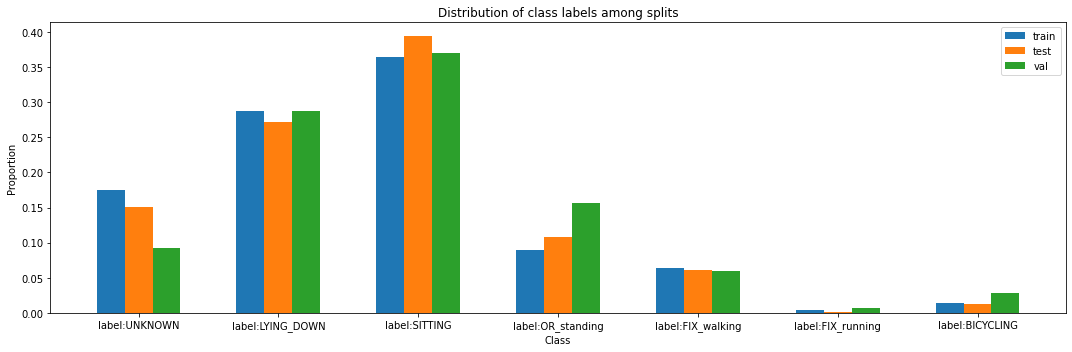

In [7]:
# What is the label distribution?
train_x, train_y = preProcess(train)
test_x, test_y = preProcess(test)
val_x, val_y = preProcess(val)
#del train_x, test_x, val_x

train_y_count = train_y.value_counts(normalize=True).sort_index()
test_y_count  = test_y.value_counts(normalize=True).sort_index()
val_y_count =  val_y.value_counts(normalize=True).sort_index()

X = main_activity_label_classes.keys()
X_axis = np.arange(len(X))

plt.figure(figsize=(15,5))
plt.bar(X_axis-0.2, train_y_count, width=0.2, label= 'train')
plt.bar(X_axis, test_y_count, width=0.2, label= 'test')
plt.bar(X_axis+0.2, val_y_count, width=0.2, label= 'val')
plt.xticks(X_axis, X)
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Class')
plt.title('Distribution of class labels among splits')
plt.tight_layout()
plt.savefig('Images/class_distribution.png')
plt.show()

In [8]:
# What is the proportion of the class unknown?
combined = pd.concat([train_y, test_y, val_y])
print(f"The proportion for the class 'UNKNOWN' is {combined.value_counts().loc[0] / combined.value_counts().sum():.3f}")

The proportion for the class 'UNKNOWN' is 0.162


In [6]:
combined, y = load_data('dataset/ExtraSensory/Processed/')

In [7]:
cols_no_check = [col for col in combined.columns if 'discrete:' in col]
cols_no_check.append('lf_measurements:battery_level')
cols_no_check.append('label_source')
cols_no_check.append('name')

In [8]:
#Delete all outliers based on lof
for col in combined.drop(columns= cols_no_check).columns:
    lof = LocalOutlierFactor(n_neighbors=20)
    y_pred = lof.fit_predict(np.array(combined[col]).reshape(-1, 1))
    combined['lof'] = y_pred
    combined.loc[combined['lof'] == -1, col] = np.nan

    unique, counts = np.unique(y_pred, return_counts=True)
    print(f"{col} has {counts[0]} outliers")

    kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])

    col_with_mask = np.ma.masked_invalid(combined[col])
    kf = kf.em(col_with_mask, n_iter=5)

    (new_data, filtered_state_covariances) = kf.filter(col_with_mask)
    combined[col] = new_data

combined = combined.drop(columns=['lof'])

#Plotten de hoeveel outliers per kolom

proc_gyro:3d:mean_z has 3925 outliers
raw_magnet:magnitude_stats:mean has 594 outliers
raw_magnet:3d:mean_y has 1597 outliers
raw_magnet:3d:mean_x has 967 outliers
raw_acc:magnitude_stats:mean has 1060 outliers
proc_gyro:3d:mean_y has 2653 outliers
proc_gyro:3d:mean_x has 2499 outliers
watch_acceleration:3d:mean_x has 1657 outliers
audio_properties:max_abs_value has 1997 outliers
watch_acceleration:magnitude_stats:mean has 1153 outliers
raw_acc:3d:mean_x has 429 outliers
watch_acceleration:3d:mean_z has 1970 outliers
proc_gyro:magnitude_stats:mean has 5164 outliers
location_quick_features:lat_change has 6849 outliers
location_quick_features:long_change has 7372 outliers
raw_acc:3d:mean_z has 310 outliers
watch_acceleration:3d:mean_y has 1410 outliers
raw_magnet:3d:mean_z has 965 outliers
raw_acc:3d:mean_y has 133 outliers


In [10]:
for i, df_user in combined.groupby('name'):
    name = df_user['name'].iloc[0]
    df_user = df_user.drop(columns=['name'])
    df_user.to_csv('dataset/ExtraSensory/Processed_outliers/' + name + '.csv', index=False)

In [5]:
from pykalman import KalmanFilter

kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])

numpy_matrix_state_with_mask = np.ma.masked_invalid(combined['raw_magnet:magnitude_stats:mean'])
kf = kf.em(numpy_matrix_state_with_mask, n_iter=5)

# And apply the filter.
(new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)



KeyboardInterrupt: 